## Exercise 1

In this exercise you need to plot ocean depth against ocean age. You have the topography / bathymetry data and the age data. You should do this for the "deep oceans" to avoid including the continental shelves and, for that matter, the continents. The age dataset is only valid where there are magnetic stripes. Other places in the grid are flagged as _"Not a Number"_ or _NaN_ and will not plot. You might have to strip out these points for plotting / curve fitting though.

### Instructions 

You can submit this notebook by email but you MUST rename it so we know who it is from. If you used a crazy pseudonym, please let us know when you submit your assigments. 

I expect to be able to run this notebook before I read your answer!

In [19]:
%pylab inline

from osgeo import gdal

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.io import netcdf
from scipy.misc import imresize

Populating the interactive namespace from numpy and matplotlib


C:\Users\court\Documents\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Hint

You will need to have the two datasets at the same resolution and valid data shape. The data are stored in an image so re-interpolation can be done with the image resizing fanciness available in ... (guess where !)

In [20]:
etopoH = gdal.Open("Resources/ETOPO1_Ice_c_geotiff.tif") 
etopoH_img = etopoH.ReadAsArray()[::4,::4]
del(etopoH)

ages = np.load("Resources/global_age_data.3.6.z.npz")["ageData"]



In [21]:
#resize depth 
etopoH_1 = imresize(etopoH_img, ages.shape, interp='bilinear', mode="F")
etopoH_1[ np.isnan(ages) ] = np.nan

C:\Users\court\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


## Task

Make a map of `etopoH_1` and `ages` (check they are the same shape and same NaN mask)

It may also help to plot plate motion arrows on the map to highlight divergent v. convergent zones. In order to do this "intuitively" you probably should choose the NNR (no net rotation) velocity field which tends to show major ridges as spreading in opposite directions. 

You will need to think about:

  * which features are useful to include (a coastline, shaded relief etc ?) 
  * plate motion arrows (see `GlobalPlateMotions` notebook) ? 

In [22]:
print (etopoH_img.shape)
print (etopoH_1.shape)
print (ages.shape)

(2700, 5400)
(1801, 3601)
(1801, 3601)


Text(0.5, 1.0, 'Ocean Age and Plate Motion')

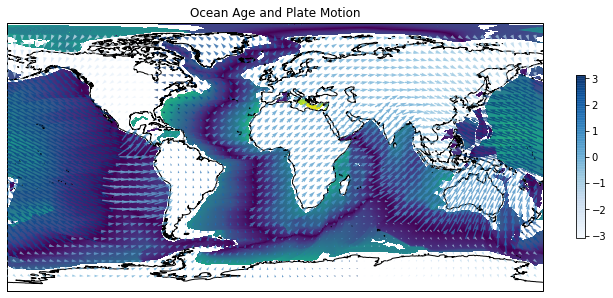

In [23]:
base_projection = ccrs.PlateCarree() 
extent = [-180, 180,-90,90]

#Plot map
fig = plt.figure(figsize=(12, 6), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.coastlines(resolution='50m', zorder=1)  
ax.imshow(ages, extent = extent, transform = ccrs.PlateCarree(), origin="upper", )


#Plate motion
rootgrp = netcdf.netcdf_file(filename="Reference/velocity_NNR.nc", version=2)

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::5]
lats = latv[::5]
llX, llY = np.meshgrid(lons,lats)

Veast = (np.array(ve[::5,::5]).T)
Vnorth = (np.array(vn[::5,::5]).T)

Vorientation = np.arctan2(Vnorth,Veast)


mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")

plt.colorbar(mappable1, shrink=0.5)
plt.title("Ocean Age and Plate Motion")
#print(llX.shape, llY.shape)          

Text(0.5, 1.0, 'Ocean Depth and Tectonic Plate Motion')

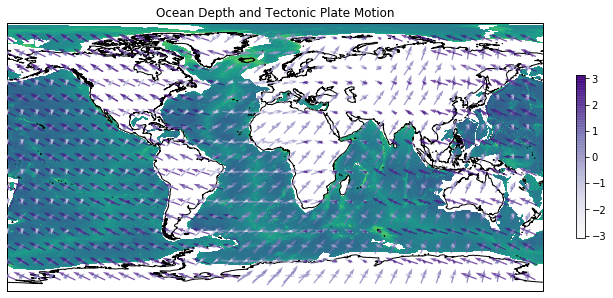

In [24]:
#Plot map
fig = plt.figure(figsize=(12, 6), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.coastlines(resolution='50m', zorder=1)  
ax.imshow(etopoH_1, extent = extent, transform = ccrs.PlateCarree(), origin="upper", )

#Plate motion
rootgrp = netcdf.netcdf_file(filename = "Reference/velocity_NNR.nc", version=2)

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::10]
lats = latv[::10]
llX, llY = np.meshgrid(lons,lats)

Veast = (np.array(ve[::5,::5]).T)
Vnorth = (np.array(vn[::5,::5]).T)

Vorientation = np.arctan2(Vnorth,Veast)


mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Purples, alpha=0.7, zorder=13, pivot="mid")

plt.colorbar(mappable1, shrink=0.5)
plt.title("Ocean Depth and Tectonic Plate Motion")

### Task

Make a scatter plot of the depth against age. You might need to downsample the number of points as there are a lot of them:

```python 
ages_decimated = ages[::10]
topo_decimated = etopoH[::10]
``` 

Do you see any systematic trend ?

**Hint:** don't worry if you do not 

In [25]:
x = ages[::100]
y = etopoH_1[::100]

In [26]:
x[~np.isnan(x)]
print (x.shape)

y[~np.isnan(y)]
print (y.shape)

(19, 3601)
(19, 3601)


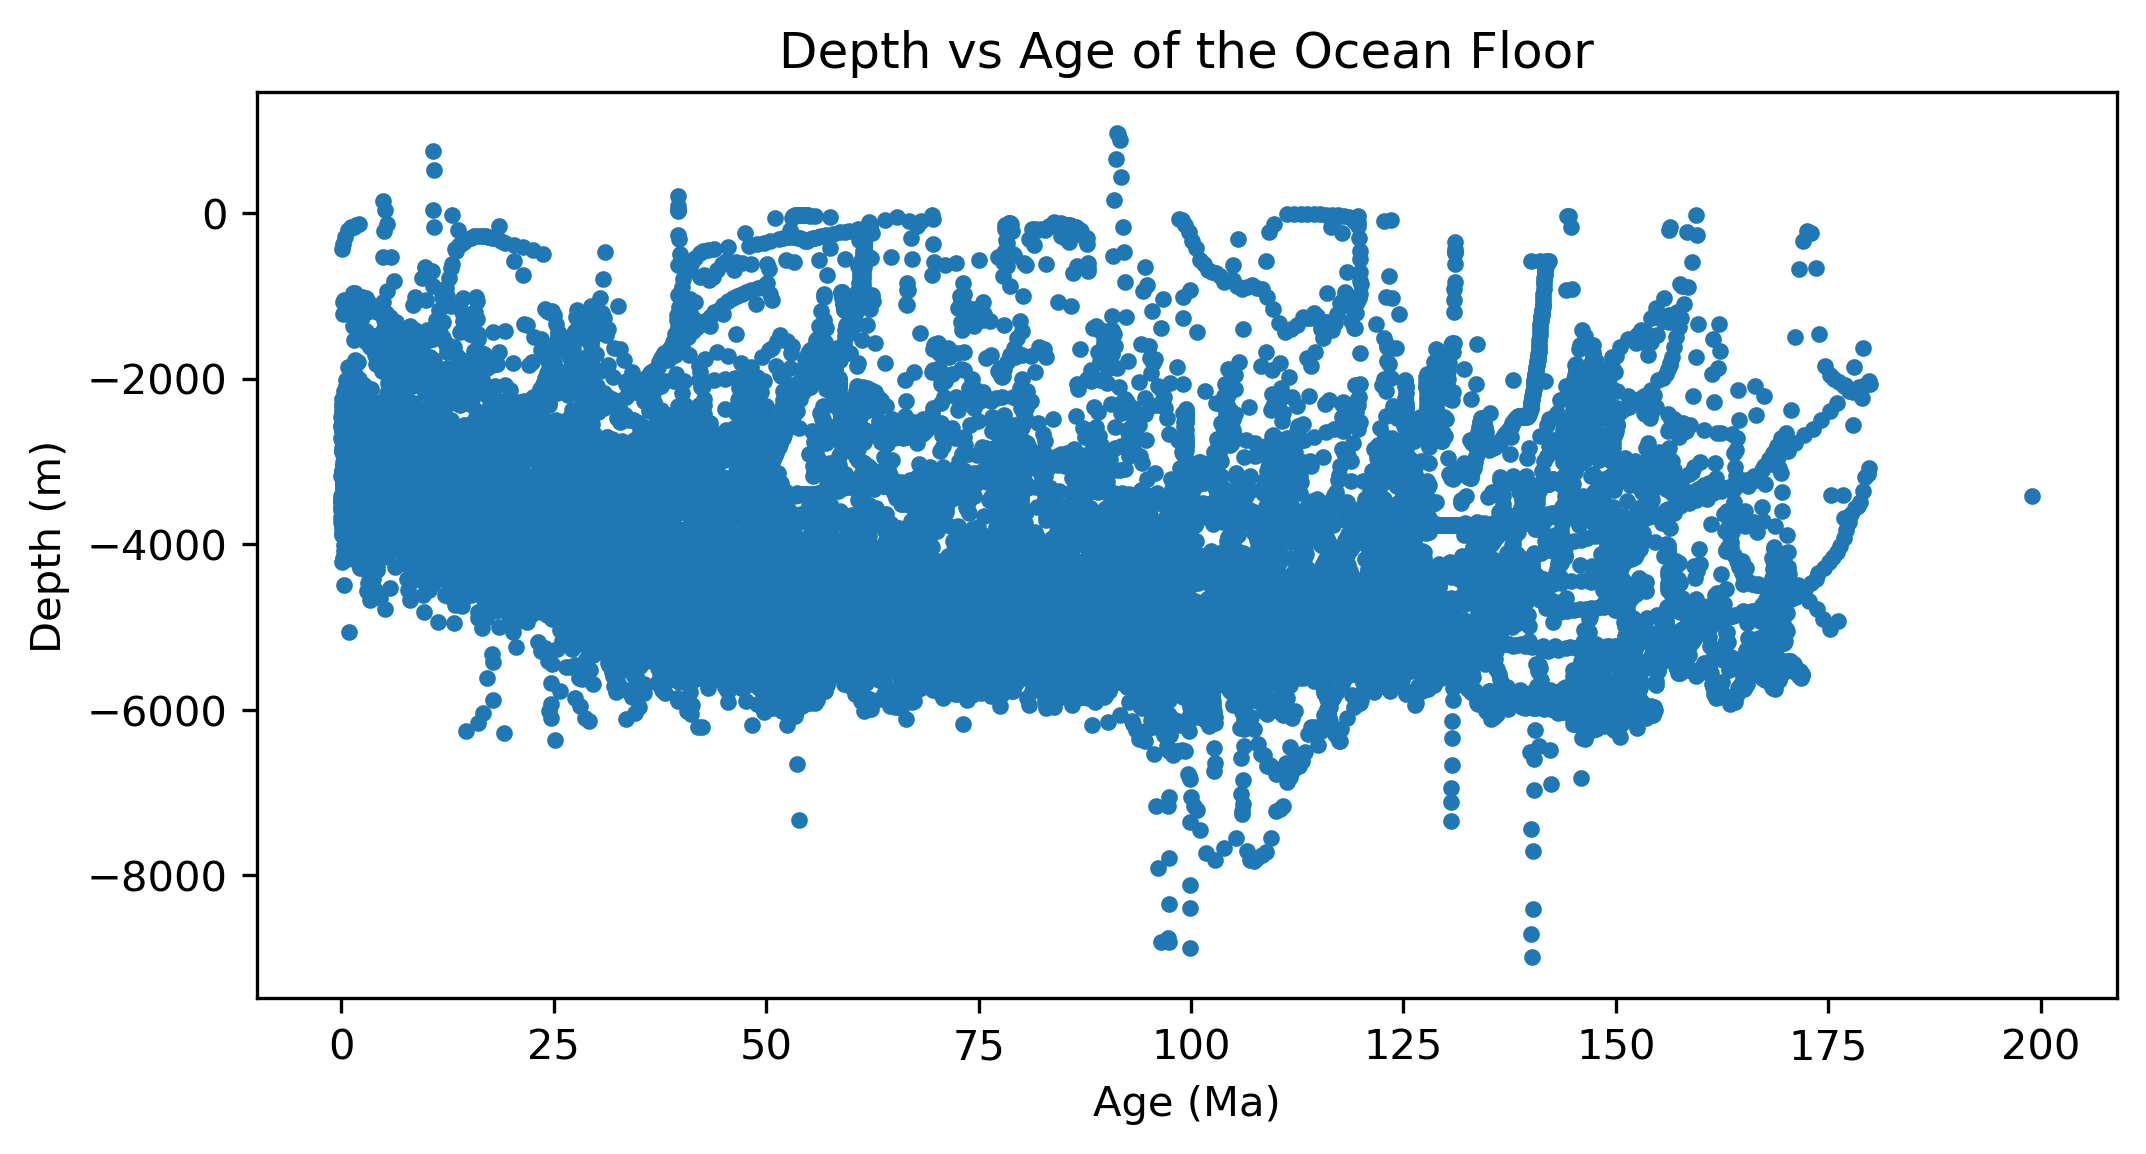

In [27]:
fig = plt.figure (figsize=(8,4), dpi = 300)
ax= plt.scatter(x,y, marker = '.')
ax = plt.ylabel('Depth (m)')
ax = plt.xlabel('Age (Ma)')
ax =plt.title('Depth vs Age of the Ocean Floor')

# This figure shows that there is no clear correlation between age and depth 

Smoothing

Now try interpolating the bathymetry to a smoothed / downsampled version of the ages.

```python
ages_reduced = ages[::8,::8] # This is arbitrary, you should try some different ones

# OR

ages_reduced2 = imresize(ages, (226,451), interp='bilinear', mode="F")

# OR

ages_reduced2 = imresize(ages, (226,451), interp='bicubic', mode="F")

# OR

ages_reduced2 = imresize(ages, (226,451), interp='lanczos', mode="F")
```

Comment on which of these is the more effective.


C:\Users\court\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
C:\Users\court\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
C:\Users\court\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
C:\Users\court\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by Intera

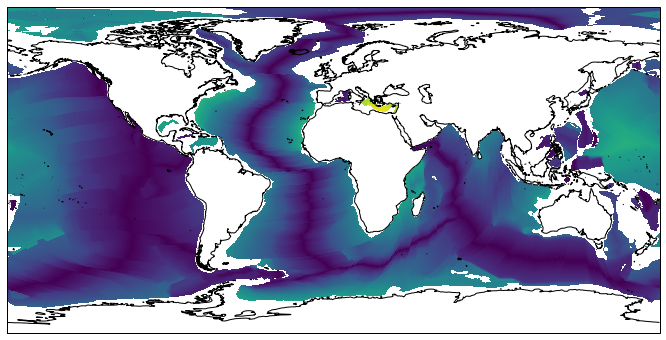

In [28]:
ages_reduced = ages[::8,::8]
ages_reduced2 = imresize(ages, (226,451), interp='bilinear', mode="F")
fig = plt.figure(figsize=(12, 6), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.coastlines(resolution='50m', zorder=1)  
ax.imshow(ages, extent = extent, transform = ccrs.PlateCarree(), origin="upper", )
ages_reduced3 = imresize(ages, (226,451), interp='bicubic', mode="F")
ages_reduced4 = imresize(ages, (226,451), interp='lanczos', mode="F")
                        
topo_reduced = etopoH_1[::8,::8]
topo_reduced2 = imresize(etopoH_1, (226,451), interp='bilinear', mode="F")
topo_reduced3 = imresize(etopoH_1, (226,451), interp='bicubic', mode="F")
topo_reduced4 = imresize(etopoH_1, (226,451), interp='lanczos', mode="F")

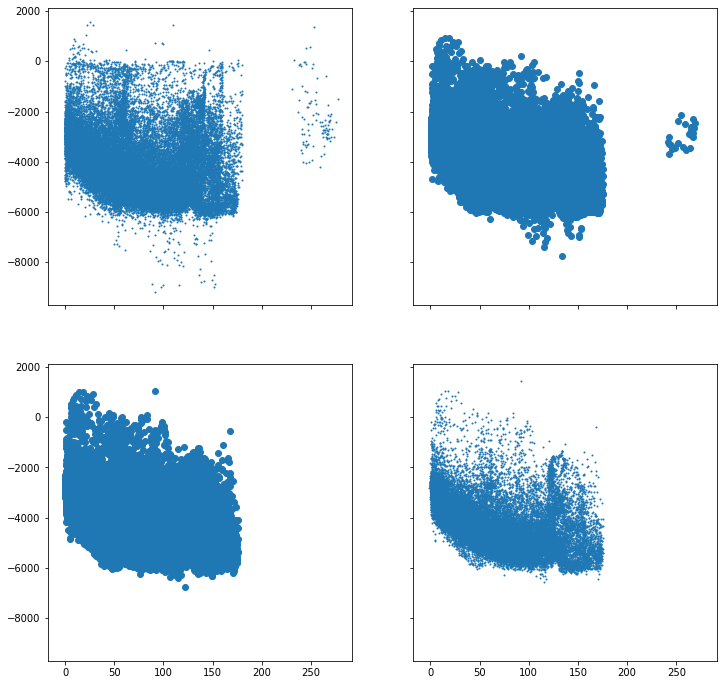

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axes = plt.subplots(ncols=2, nrows=2, sharex='all', sharey='all')
ax1, ax2, ax3, ax4 = axes.ravel()
fig.set_size_inches((12,12))

ax1.scatter(ages_reduced, topo_reduced, s=1)
ax2 = ax2.scatter(ages_reduced2, topo_reduced2)
ax3 = ax3.scatter(ages_reduced3, topo_reduced3)
ax4 = ax4.scatter(ages_reduced4, topo_reduced4, s=1)

### Task

Plot the age/depth data and see if it looks smoother.

Make a scatterplot with this data too (note: you will have to downsample the bathymetry too)

Does smoothing help bring out a trend ?


## Therefore smoothing does somewhat bring out a negative trend

In [30]:
x = ages_reduced4
y = topo_reduced4
x.shape, y.shape

((226, 451), (226, 451))

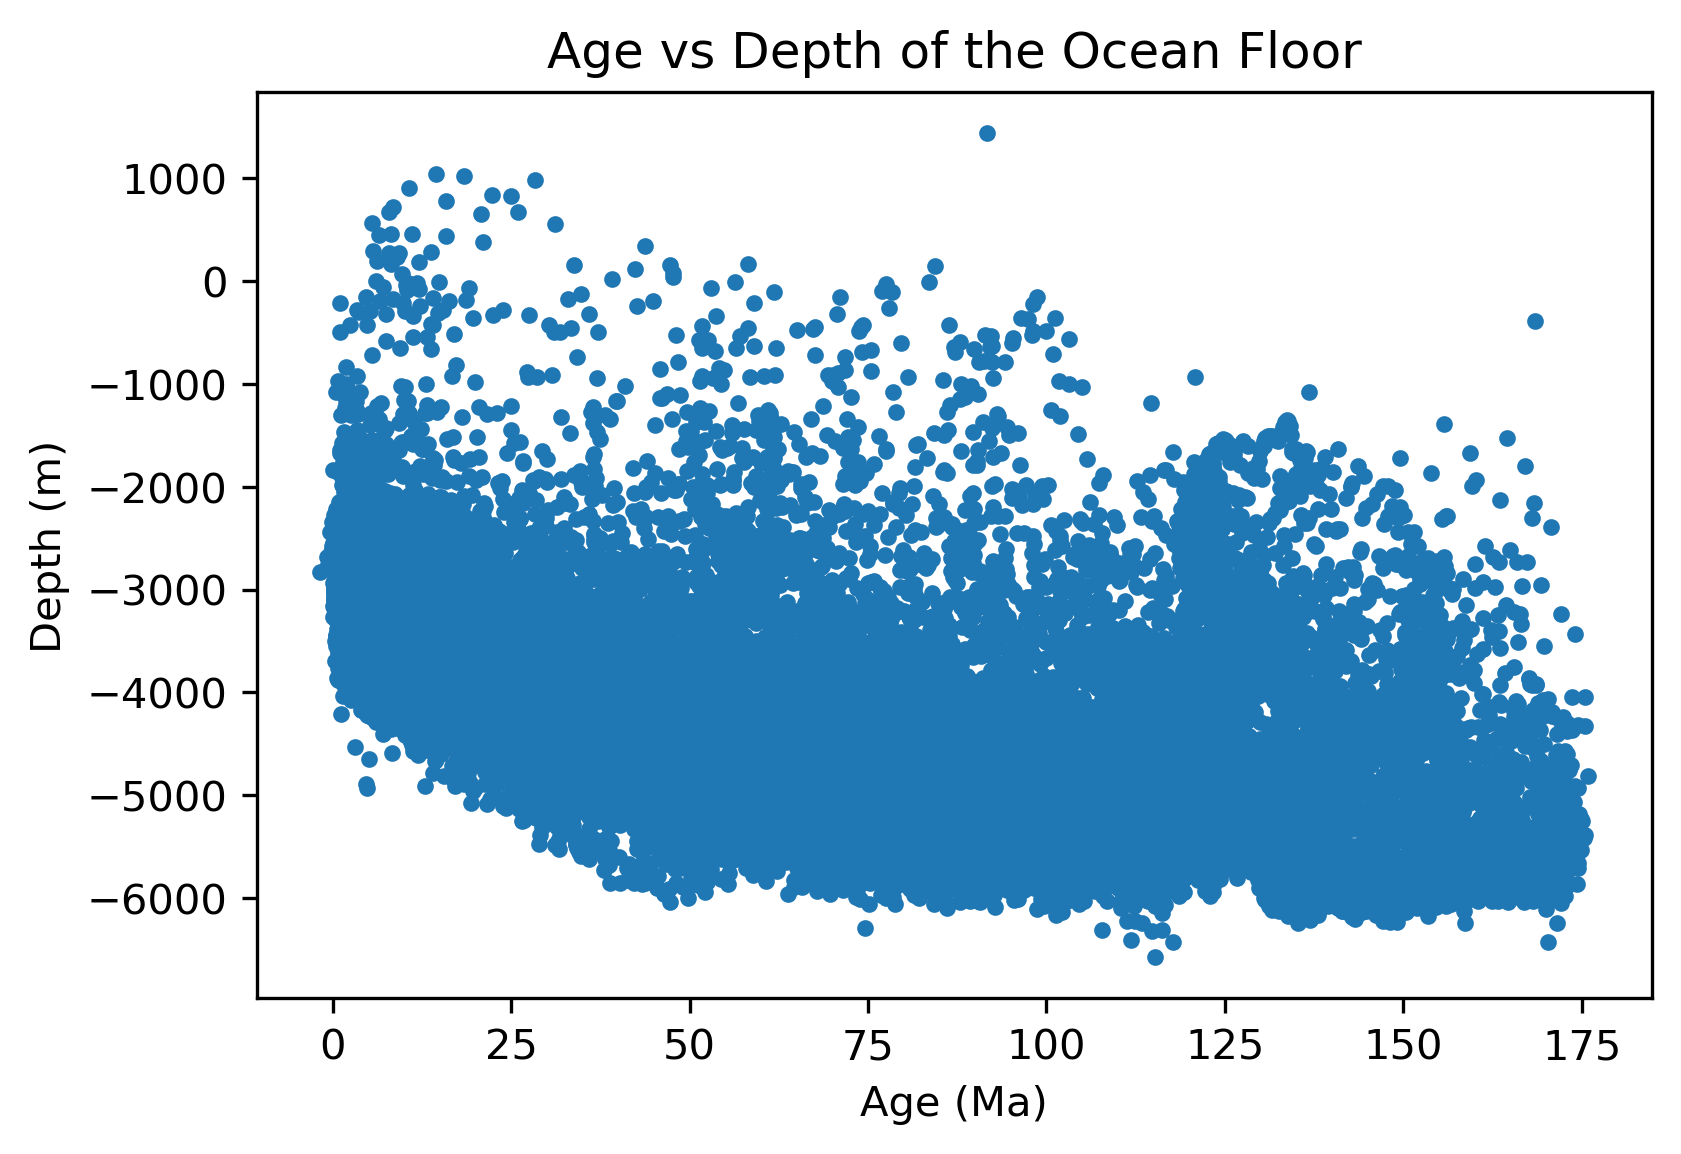

In [31]:
fig = plt.figure (figsize=(6,4), dpi = 300)
ax= plt.scatter(x,y, marker = '.')
ax = plt.ylabel('Depth (m)')
ax = plt.xlabel('Age (Ma)')
ax =plt.title('Age vs Depth of the Ocean Floor')

### Task

Fit $ \textrm{depth} = A + B\sqrt{\textrm{age}} $ to this data and create a plot

You should be able to use 

```python
from scipy.optimize import curve_fit
help(curve_fit)
```



In [41]:
maskage = ages_reduced4 > 0

ages_reduced5 = ages_reduced4[maskage]
topo_reduced5 = topo_reduced4[maskage]

print(topo_reduced5.shape)
print(topo_reduced6.shape)
print(ages_reduced5.shape)
print(ages_reduced6.shape)

(40410,)
(40372,)
(40410,)
(40372,)


C:\Users\court\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [42]:
depth_mask = topo_reduced5 < 0
ages_reduced6 = ages_reduced5[depth_mask]
topo_reduced6 = topo_reduced5[depth_mask]

print(topo_reduced5.shape)
print(ages_reduced5.shape)

print(topo_reduced6.shape)
print(ages_reduced6.shape)

(40410,)
(40410,)
(40372,)
(40372,)


In [44]:
np.isfinite(ages_reduced6).all()

True

In [46]:
from scipy.optimize import curve_fit
#help(curve_fit)

x=np.arange(0,200,10)

def function (x,A,B):
    return A + B*sqrt(x)

popt, pcov = curve_fit(function, ages_reduced6, topo_reduced6)
print ("function(x. a={}, b={})".format(popt[0],popt[1]))


function(x. a=-3166.277966789412, b=-159.51863795854726)


Therefore

A = -3166.277966789412
B = -159.51863795854726

Text(0.5, 1.0, 'Age and Depth Line of Best Fit')

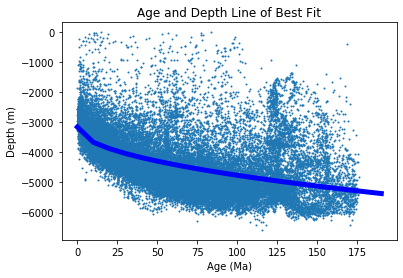

In [48]:
# plot curve of best fit. plot A and B, x data

plt.plot(x, function(x, -3154.59045955, -160.60203339), linewidth=5, color='blue')
plt.scatter(ages_reduced6, topo_reduced6, s=1)
plt.xlabel('Age (Ma)')
plt.ylabel('Depth (m)')
plt.title('Age and Depth Line of Best Fit')